### HW1

**Author**: Ben Peloquin
    
**Date**: 20190406

In [1]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import tqdm

from hw1_utils import *

sns.set_style("whitegrid")

%matplotlib inline

Load data

In [2]:
data_fp = "ventral_neural_data.hdf5"
d_ventral = h5py.File(data_fp, 'r')
print(d_ventral.keys())

[u'image_meta', u'images', u'neural_meta', u'time_averaged', u'time_averaged_trial_averaged', u'time_binned', u'time_binned_trial_averaged']


Utils

In [3]:
def dimnames(dataset):
    dims = dataset.dims  #get the dimension object
    dimlist = [x.label for x in dims.keys()]  #get the label attribute
    dimlist = map(str, dimlist)  #cast everything to string instead of "unicode" ... complicated rathole ... not strictly necessary
    return dimlist

In [27]:
#let's get the IT neural data -- time and trial averaged
d_neural = d_ventral['time_averaged_trial_averaged']
it_neurons = d_ventral['neural_meta']['IT_NEURONS']
d_it_neurons = d_neural[:, it_neurons]

#... and remind ourselves of the tensor shape
# print('Shape:', d_it_neurons.shape)
# print('Dimensions:', list(dimnames(d_neural)))

Basic data

In [5]:
d_time_averaged = d_ventral['time_averaged']
print(d_time_averaged['variation_level_0'].shape)
print(d_time_averaged['variation_level_3'].shape)
print(d_time_averaged['variation_level_6'].shape)
print("Reminder about dims:")
print(list(d_time_averaged['variation_level_0'].dims.keys()))

(28, 640, 296)
(51, 2560, 296)
(47, 2560, 296)
Reminder about dims:
[<"trial" dimension 0 of HDF5 dataset at 112152050288>, <"image" dimension 1 of HDF5 dataset at 112152050288>, <"neuron" dimension 2 of HDF5 dataset at 112152050288>]


## Problem 1: Reliability computation on time-averaged responses

Outstanding things (Ben / Marc):
* Do we want to aggregate over conditions?
* Can we use random indices permutations for all neurons? (for runtime efficiency)

### Reliability of each neuron

* First compute the reliability for each neuron using the methods described in the class
* Perform a significance test on the population of all the neurons to determine whether the population is significantly reliable or not

In the report, please describe your methods for computing the reliability, choose your own significance level, and report the results of significance test properly (refer to section 3 for details).

[BP] We'll use `split-half reliability` to compute reliability for each neuron. This means we're going to look at average activation for each neuron, aggregating over objects and conditions.

Remember from class we concluded that `having num_splits ~ 10 * num_trials is good enough`

In [6]:
d_time_averaged['variation_level_0'].shape

(28, 640, 296)



For this first question, we're going to aggregate over specific images, trials and conditions.

In [16]:
# Get average trial data by averaging for images???
# Combine conditions???
# d_neuron_by_trial = np.concatenate([np.mean(d_time_averaged['variation_level_0'], axis=1),
#                                     np.mean(d_time_averaged['variation_level_3'], axis=1),
#                                     np.mean(d_time_averaged['variation_level_6'], axis=1)])

d_neuron_by_trial = d_time_averaged['variation_level_0']
print(d_neuron_by_trial.shape)

(28, 640, 296)


In [8]:
reliabilities = get_all_neuron_reliabilities(d_neuron_by_trial, 20, 10)
reliabilities.shape

100%|██████████| 296/296 [02:16<00:00,  2.17it/s]


In [17]:
# num_splits = 10
# num_trials = 20
# results = []
# for split_idx in tqdm.tqdm(range(num_splits)):
#     first_half, second_half = create_random_split(d_neuron_by_trial, num_trials, split_idx)
#     d_first_half = np.array(d_neuron_by_trial)[:, first_half, :].mean(1)
#     d_second_half = np.array(d_neuron_by_trial)[:, second_half, :].mean(1)
#     rs = []
#     for neuron_idx in range(d_first_half.shape[1]):
#         rs.append(stats.pearsonr(d_first_half[:, neuron_idx], d_second_half[:, neuron_idx])[0])
#     results.append(np.array(rs))
# results = np.stack(results)    

In [12]:
# Get neuron population mean and standar deviation
means = np.mean(reliabilities, axis=1)
stds = np.std(reliabilities, axis=1)

### Reliability by neuron

Text(0.5,0,'Neuron')

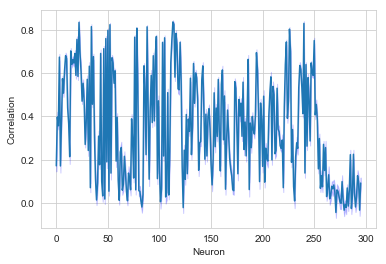

In [13]:
neurons = np.arange(296)
plt.plot(neurons, means)
plt.fill_between(neurons, means - stds, means + stds, color='b', alpha = 0.2)
plt.ylabel("Correlation")
plt.xlabel("Neuron")

### Population-level reliability

Just inspecting this plot we'd conclude that none of the individual neurons look significantly reliable.

We can test this formally assessing whether the population average is significantly different from 0.

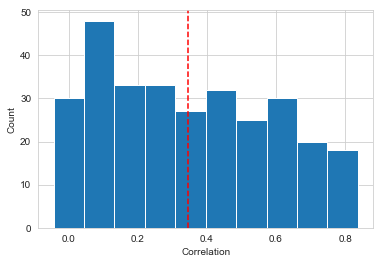

In [14]:
plt.hist(means)
plt.ylabel("Count")
plt.xlabel("Correlation")
plt.axvline(x=np.mean(means), c='red', ls='--')

In [19]:
n = len(means)
stats.ttest_1samp(means, 0.)

Ttest_1sampResult(statistic=24.318922365628666, pvalue=1.8899296803534524e-72)

* To compute the reliability for a single neuron we used the split-half using `20 splits` with `10 trials` each. For each neuron this gave 20 reliability estimates we used to compute the mean and std.
* We examined the distribution over mean reliability measures for the entire population in the histogram plot and performed a t-test to assess whether the average reliability was significantly different than 0. We found that the population was significantly reliable.
```
 t(295) = 24.31, p < 1e-70
```

### Reliability by areas

Test whether reliability of V4 neurons is significantly different from that of IT neurons.
* Choose a significance level and report the significance test results properly. 


In [38]:
IT_neurons = d_ventral['neural_meta']['IT_NEURONS']
v4_neurons = d_ventral['neural_meta']['V4_NEURONS']
d_it = np.array(d_time_averaged['variation_level_0'])[:, :, IT_neurons]
d_v4 = np.array(d_time_averaged['variation_level_0'])[:, :, v4_neurons]

In [37]:
len(v4_neurons)

128

In [ ]:
it_reliabilities = get_all_neuron_reliabilities(d_it, 40, 20)
v4_reliabilities = get_all_neuron_reliabilities(d_v4, 40, 20)




  0%|          | 0/168 [00:00<?, ?it/s]


  1%|          | 1/168 [00:00<01:37,  1.71it/s]


  1%|          | 2/168 [00:01<01:33,  1.77it/s]


  2%|▏         | 3/168 [00:01<01:31,  1.81it/s]


  2%|▏         | 4/168 [00:02<01:27,  1.88it/s]


  3%|▎         | 5/168 [00:02<01:24,  1.93it/s]


  4%|▎         | 6/168 [00:03<01:21,  1.98it/s]


  4%|▍         | 7/168 [00:03<01:21,  1.98it/s]


  5%|▍         | 8/168 [00:04<01:19,  2.00it/s]


  5%|▌         | 9/168 [00:04<01:19,  2.01it/s]


  6%|▌         | 10/168 [00:05<01:20,  1.95it/s]


  7%|▋         | 11/168 [00:05<01:19,  1.98it/s]


  7%|▋         | 12/168 [00:06<01:18,  1.99it/s]


  8%|▊         | 13/168 [00:06<01:16,  2.02it/s]


  8%|▊         | 14/168 [00:07<01:15,  2.03it/s]


  9%|▉         | 15/168 [00:07<01:14,  2.04it/s]


 10%|▉         | 16/168 [00:08<01:14,  2.04it/s]


 10%|█         | 17/168 [00:08<01:15,  2.00it/s]


 11%|█         | 18/168 [00:09<01:24,  1.78it/s]


 11%|█▏        | 19/168 [00:09<01:21,  1.83it/

 81%|████████  | 136/168 [01:32<00:39,  1.23s/it]


 82%|████████▏ | 137/168 [01:33<00:34,  1.11s/it]


 82%|████████▏ | 138/168 [01:34<00:31,  1.06s/it]


 83%|████████▎ | 139/168 [01:35<00:30,  1.06s/it]


 83%|████████▎ | 140/168 [01:36<00:29,  1.06s/it]


 84%|████████▍ | 141/168 [01:37<00:27,  1.02s/it]


 85%|████████▍ | 142/168 [01:38<00:25,  1.01it/s]


 85%|████████▌ | 143/168 [01:39<00:26,  1.04s/it]


 86%|████████▌ | 144/168 [01:40<00:25,  1.04s/it]

In [48]:
def hist_plot(a, b, a_name=None, b_name=None):
    l0 = plt.hist(a, bins=20);
    l1 = plt.hist(b, bins=20, alpha=0.5);
    if a_name is not None and b_name is not None:
        plt.legend([l0[2][0], l1[2][0]], [a_name, b_name])
    plt.xlabel('Reliabilities (r)')
    plt.ylabel('Count')

In [49]:
it_means = it_reliabilities.mean(1)
v4_means = v4_reliabilities.mean(1)
it_std = it_reliabilities.std(1)
v4_std = v4_reliabilities.std(1)

In [91]:
np.concatenate((d_time_averaged['variation_level_0'], d_time_averaged['variation_level_6']), axis=2).shape

ValueError: all the input array dimensions except for the concatenation axis must match exactly

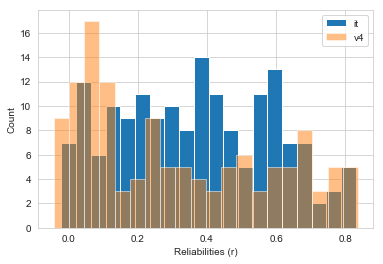

In [51]:
hist_plot(it_means, v4_means, 'it', 'v4')

In [53]:
n = len(means)
stats.ttest_ind(it_means, v4_means)

Ttest_indResult(statistic=1.7495727787055197, pvalue=0.08123543114962795)